# Case Study of Tip Percentage on NYC Taxi Data (By Xuan Zhou)

## 1. Introduction 
### 1.1 Background Information
This is a supervised learning problem which I want to make predictions on tip as a percentage of the total fare given the 21 features in the green taxi trip dataset from September 2015.

We can learn following important information from the Data Set Description:
* The data sets were collected and provided to the NYC Taxi and Limousine Commission (TLC).
* The trip data was not created by the TLC, and TLC makes no representations as to the accuracy of these data.
* Green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

### 1.2 Supervised Learning Method
* For this problem, I will try to use stochastic gradient boosting to sovle it.

### 1.3 Avoid Overfitting
* Use Out-of-bag error(OOB) to determine the best model and avoid overfitting. In this case, if we use too many trees in the stochastic gradient boosting, it could lead to overfitting.

### 1.4 Model Assessment
* I analyze the models through assess the mean square error and the mean absolute error of the results.

* After cleaning the data, the model is trained on the 80% of data (1,165,230 Observations), and tested on 20% data (291,307 Observations).

### 1.5 Content
There are four main parts to my script as follows:

* Data Preprocessing
* Feature Engineering
* Build Model
* Model Result and Analysis

## 2. Data Preprocessing
### 2.1 Import Data and Check Missing Values

In [116]:
import numpy as np
from numpy.random import choice
import pandas as pd
from datetime import datetime
import scipy.stats as stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from matplotlib import pyplot as plt, style
import seaborn as sns
style.use('ggplot')
%matplotlib inline

In [117]:
# Load NYC Taxi and Limousine trip record data in September 2015
green_taxi = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv', 
                         header = 0)

In [118]:
# Get number of rows and columns of data
n_rows, n_cols = green_taxi.shape

print("Number of Rows: ", n_rows)
print("Number of Columns: ", n_cols)

Number of Rows:  1494926
Number of Columns:  21


In [119]:
# Show missing values for each column
green_taxi.isnull().sum()

VendorID                       0
lpep_pickup_datetime           0
Lpep_dropoff_datetime          0
Store_and_fwd_flag             0
RateCodeID                     0
Pickup_longitude               0
Pickup_latitude                0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1494926
improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                      4
dtype: int64

In [120]:
# The Ehail_fee column is totally empty, so I drop it
green_taxi.drop('Ehail_fee', axis = 1, inplace = True)

There is only 4 observation missing in the Trip_type column, consider the size of the data set, I will delete this four rows and check again the data to make sure there is no missing value in it.

In [121]:
# Drop NA rows
green_taxi = green_taxi.dropna().reset_index(drop=True)
print('Dimentionality of the Data:', green_taxi.shape)
print('The Number of Missing Values: ', green_taxi.isnull().sum().sum())

Dimentionality of the Data: (1494922, 20)
The Number of Missing Values:  0


In [125]:
# Change data type of lpep_pickup_datetime and Lpep_dropoff_datetime to datetime
green_taxi['lpep_pickup_datetime'] = pd.to_datetime(green_taxi['lpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S.%f')
green_taxi['Lpep_dropoff_datetime'] = pd.to_datetime(green_taxi['Lpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S.%f')

### 2.2 Detect Bad Data and Outliers
The purpose of this section is to find out the bad data sample or outliers which indicate the data do not make any sense. 

#### 2.21 Features Equal 0
* In a real situation if the trip distance is equal to 0, the total amount should also be 0. If not, there should be something wrong with these records.
* Passenger_count means the number of passengers in the vehicle. Thus, it cannot be 0.

In [137]:
# The number of trip distance is equal to 0 or total amount is equal to 0 or the number of passengers is equal to 0
print('Number of Rows of the Bad Data:',
      sum((green_taxi.Trip_distance == 0) | (green_taxi.Total_amount == 0) | (green_taxi.Passenger_count == 0)))

Number of Rows of the Bad Data: 24208


In [138]:
# Get the bad data (Trip_distance == 0 | Total_amount == 0 | Passenger_count == 0)
bad_data = green_taxi.ix[(green_taxi.Trip_distance == 0) | (green_taxi.Total_amount == 0) | (green_taxi.Passenger_count == 0), :]

At this point, I focus on building the predictive model. Due to the small amount of bad data(totaly around 1.6% of the entire data set), I will going to delete these observations.

In [139]:
# Delete the bad data
green_taxi = green_taxi.drop(bad_data.index.values).reset_index(drop=True)

For prediction purpose, I am going to delete some useless columns based on the data dictionary.
* VendorID is a code indicating the LPEP provider.
* Store_and_fwd_flag is the flag indicating whether the trip record was held in vehicle memory before sending to the vendor.

In [140]:
# Delete the useless columns
green_taxi.drop(['VendorID', 'Store_and_fwd_flag'], axis = 1, inplace = True)

In [141]:
# Set a random seed and split the data to training data and testing data
np.random.seed(123)
train_num = choice(np.arange(len(green_taxi)), round(len(green_taxi) * 0.8), replace=False)
train_data = green_taxi.ix[train_num]

test_num = np.setdiff1d(np.arange(len(green_taxi)), train_num)
test_data = green_taxi.ix[test_num]

#### 2.22 Analyze the Outliers in the Numerical Features
Based on the data dictionary, I group two set of data. One is small range set, another is large range set.

In [142]:
# Small range set and large range set
small_set = ['RateCodeID', 'Passenger_count', 'Extra', 'MTA_tax', 'improvement_surcharge', 'Payment_type', 'Trip_type ']
large_set = ['Trip_distance', 'Fare_amount', 'Tip_amount', 'Tolls_amount', 'Total_amount' ] 

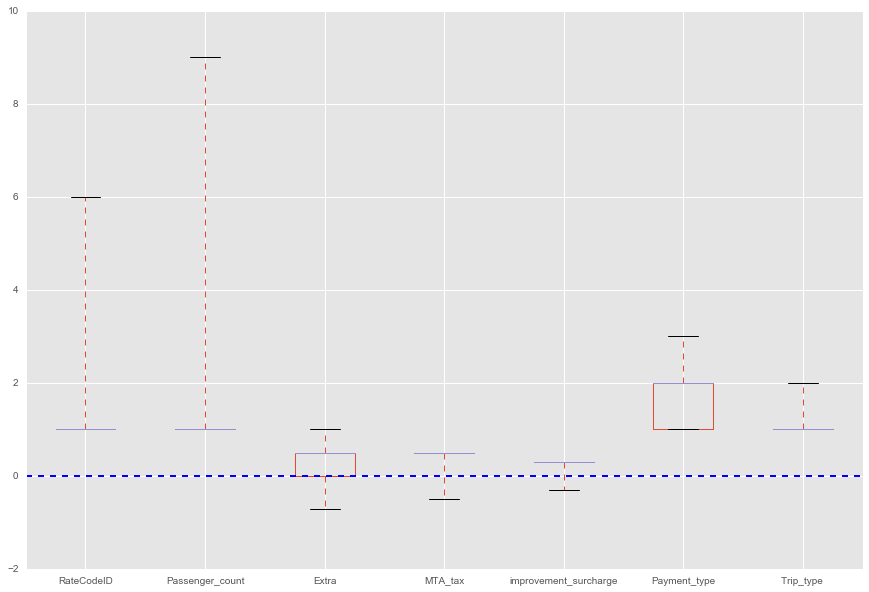

In [143]:
# Boxplot for small range set
plt.figure(figsize = (15,10))
train_data[small_set].boxplot(return_type='axes')
plt.axhline(y=0, xmin=0, xmax=(len(small_set)), color='b', linewidth=2, ls = '--',)

Clear, Extra, MIA_tax and improvement_surcharge features have negative values, which should be incorrect records.

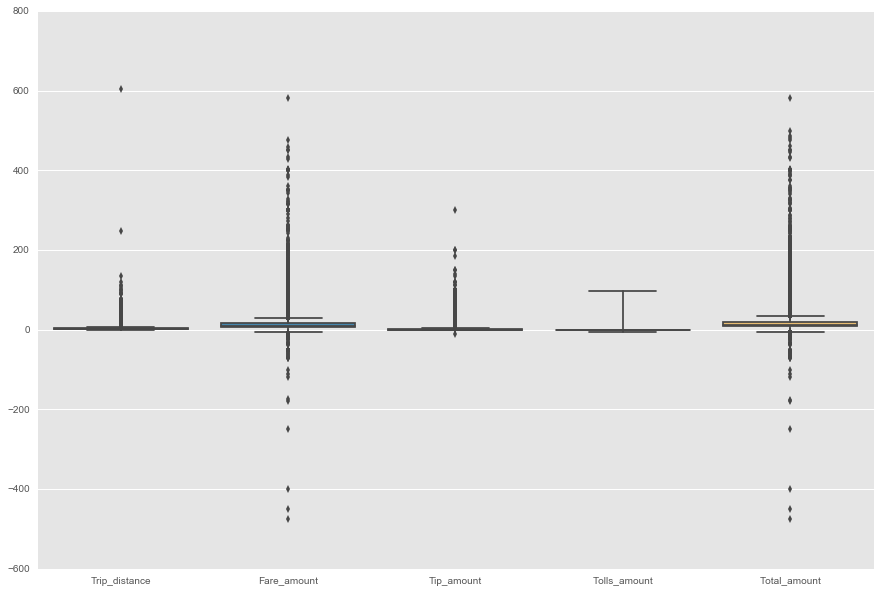

In [144]:
# Boxplot for large range set
plt.figure(figsize = (15,10))
sns.boxplot(data = train_data[large_set])

* In this boxplot, there are some negative values in the Fare_amount, Tip_amount, Tolls_amount and Total_amount columns, which also should be incorrect records. 
* Another thing is the maximum Trip_distance is around 600. It is even greater than the maximum Total_amount, which should be impossible.

In [145]:
# The number of Extra, MIA_tax, improvement_surcharge, Fare_amount, Tip_amount, Tolls_amount and Total_amount less than 0
print('Number of Rows of the Negative Data:',
      sum((green_taxi.Extra < 0) | (green_taxi.MTA_tax < 0) | (green_taxi.improvement_surcharge < 0) 
          | (green_taxi.Fare_amount < 0) | (green_taxi.Tip_amount < 0) | (green_taxi.Tolls_amount < 0) 
          | (green_taxi.Total_amount < 0)))

# Get the negative data 
neg_data = green_taxi.ix[(green_taxi.Extra < 0) | (green_taxi.MTA_tax < 0) | (green_taxi.improvement_surcharge < 0) 
          | (green_taxi.Fare_amount < 0) | (green_taxi.Tip_amount < 0) | (green_taxi.Tolls_amount < 0) 
          | (green_taxi.Total_amount < 0), :]

Number of Rows of the Negative Data: 1811


Again, due to the small amount of negative data(totaly around 0.1% of the entire data set), I will going to delete these observations.

In [146]:
# Delete the negative data
green_taxi.drop(neg_data.index.values, inplace = True)

# Delete the outlier in Trip_distance
outlier = green_taxi.ix[green_taxi.Trip_distance == green_taxi.Trip_distance.max(), :].index.values
green_taxi = green_taxi.drop(outlier).reset_index(drop=True)

# Reassign training data and test data
np.random.seed(123)
train_num = choice(np.arange(len(green_taxi)), round(len(green_taxi) * 0.8), replace=False)
train_data = green_taxi.ix[train_num]

test_num = np.setdiff1d(np.arange(len(green_taxi)), train_num)
test_data = green_taxi.ix[test_num]

### 2.3 Analyze the Correlation Between Numerical Features

In [147]:
# Obtain all the numeric columns
numeric_feature = []
columns = train_data.columns.values
for column in columns:
    if (train_data[column].dtype == np.int64) or (train_data[column].dtype == np.float64):
        numeric_feature.append(column) 

# Delete the column we are not interested
numeric_feature.remove('Pickup_longitude')
numeric_feature.remove('Pickup_latitude')
numeric_feature.remove('Dropoff_longitude')
numeric_feature.remove('Dropoff_latitude')

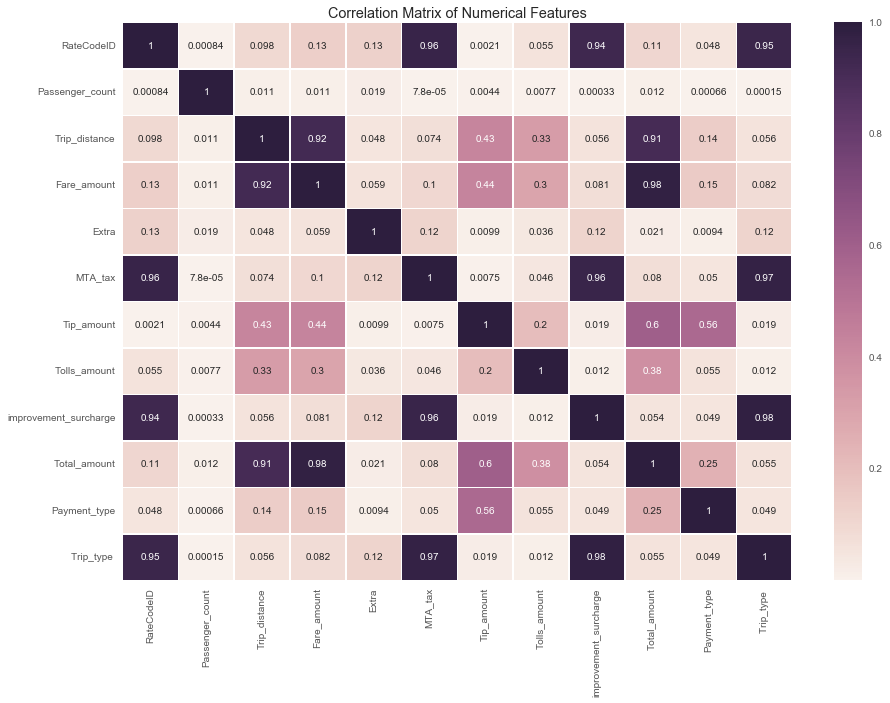

In [148]:
# Show Correlation Between Numerical Features
cor_matrix = train_data[numeric_feature].corr().abs()
plt.subplots(figsize = (15, 10))
sns.heatmap(cor_matrix, annot = True, linewidths = 0.5)
plt.title('Correlation Matrix of Numerical Features')

Based on the correlation matrix, we can see there are several features are strong correlated with each other. 
This make sense because 
* Total_amount = Fare_amount + Extra + MTA_tax + Tip_amount + Tolls_amount + improvement_surcharge. 
* Total_amount and Trip_distance have high positive correlatation.

Others have low correlatation with each other.

## 3. Feature Engineering

### 3.1 Create New Features
* Create a trip duration (unit: hour) feature: duration = Lpep_dropoff_datetime - lpep_pickup_datetime
* Create an average speed feature: avg_speed = Trip_distance / duration

In [149]:
# Create a trip duration feature, unit is hour
green_taxi['duration'] = green_taxi['Lpep_dropoff_datetime'] - green_taxi['lpep_pickup_datetime']
green_taxi['duration'] = green_taxi['duration'] / np.timedelta64(1, 'h')

The Number of Rows that Trip Distance Equal 0: 141


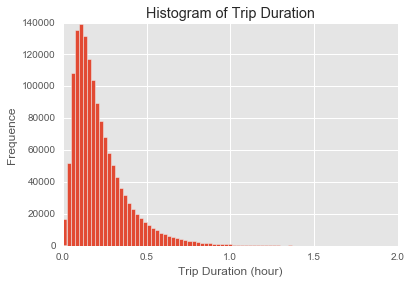

In [150]:
# Show histogram of trip duration
green_taxi['duration'].hist(bins = 1000)
plt.xlim((0,2))
plt.title("Histogram of Trip Duration")
plt.xlabel('Trip Duration (hour)')
plt.ylabel('Frequence')

# Print the number of rows that trip duration equal 0
print('The Number of Rows that Trip Distance Equal 0:', sum(green_taxi['duration'] == 0))

From the graph above, there also have some bad data which indicate the trip duration equals 0. Again due to the small size of these data, I will delete them.

In [151]:
# Delete the trip duration equal 0 data
duration_0 = green_taxi.ix[green_taxi['duration'] == 0, :].index.values
green_taxi = green_taxi.drop(duration_0).reset_index(drop=True)

In [152]:
# Create an average speed feature
green_taxi['avg_speed'] = green_taxi.Trip_distance / green_taxi.duration

Based on the common sense, the avg_speed(mile/hr) cannot greater than 120 or less than 1. Thus, we need to deal with these outliers.

In [153]:
print('The Number of Rows of Bad Average Speed:', sum((green_taxi['avg_speed']> 120) | (green_taxi['avg_speed'] < 1)))

The Number of Rows of Bad Average Speed: 12224


In [154]:
# Delete the bad average speed data
avg_speed_bad = green_taxi.ix[(green_taxi['avg_speed']> 120) | (green_taxi['avg_speed'] < 1), :].index.values
green_taxi = green_taxi.drop(avg_speed_bad).reset_index(drop=True)

## 4. Build Model
### 4.1 Stochastic Gradient Boosting
Use stochastic gradient boosting algorithm to predict the tip as a percentage of the total fare.

In [155]:
# Create the label in the data set: tip as a percentage of the total fare
green_taxi['tip_pct'] = green_taxi.Tip_amount / green_taxi.Total_amount

# Reassign training data and test data
np.random.seed(123)
train_num = choice(np.arange(len(green_taxi)), round(len(green_taxi) * 0.8), replace=False)
train_data = green_taxi.ix[train_num]

test_num = np.setdiff1d(np.arange(len(green_taxi)), train_num)
test_data = green_taxi.ix[test_num]

In [156]:
# Format training data
X = np.array(train_data.drop(['lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude','Pickup_latitude', 
                              'Dropoff_longitude', 'Dropoff_latitude', 'Tip_amount', 'Total_amount','tip_pct'], axis = 1))
# Scale the data
X = preprocessing.scale(X)

y = np.array(train_data['tip_pct'])

In [157]:
# Build model
reg = GradientBoostingRegressor(loss='ls', n_estimators=800, learning_rate=0.01, 
                                max_depth=1, random_state=123, subsample = 0.9)
reg = reg.fit(X, y)

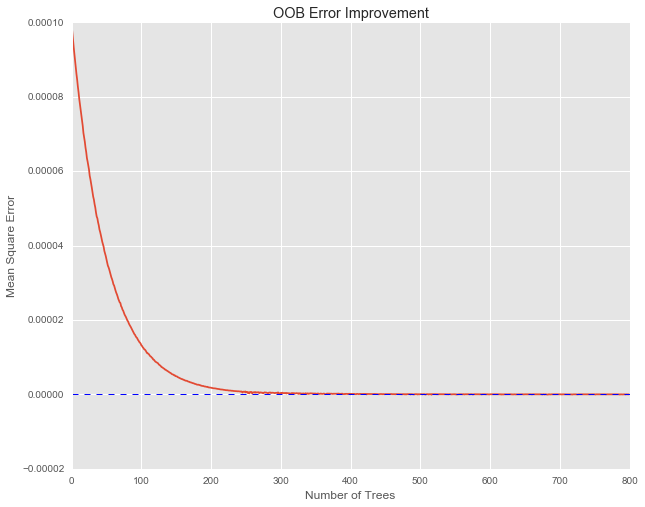

In [158]:
# Show OOB Error Improvement
plt.subplots(figsize = (10, 8))
plt.plot(reg.oob_improvement_)
plt.title('OOB Error Improvement')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Square Error')
plt.axhline(y=0, xmin=0, xmax=800, color='b', linewidth=1, ls = '--',)

In [159]:
# Format testing data
X_test = np.array(test_data.drop(['lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude','Pickup_latitude', 
                                  'Dropoff_longitude', 'Dropoff_latitude', 'Tip_amount', 'Total_amount', 'tip_pct'], axis = 1))
# Scale the data
X_test = preprocessing.scale(X_test)

y_test = np.array(test_data['tip_pct'])

### 4.2 Tip Percentage Must Fall Between 0 and 1
Cap and floor the results of my predictions.
* If my predicted tip percentage < 0, reassign it = 0.
* If my predicted tip percentage > 1, reassign it = 1.

In [160]:
# Calculate our predicted tip percentage 
pred = reg.predict(X_test)

# Cap and floor the predictions
pred[pred < 0] = 0
pred[pred > 1] = 1

## 5. Model Result and Analysis
### 5.1 Model Result

In [161]:
# Calculate the mean square error (MSE) for testing data
print('The Test Mean Square Error:', round(sum((pred - y_test)**2) / len(y_test), 10))

# Calculate the mean absolute error (MAE)  for testing data
print('The Test Mean Absolute Error:', round(sum(abs(pred - y_test)) / len(y_test), 10))

The Test Mean Square Error: 0.0024959947
The Test Mean Absolute Error: 0.0265331485


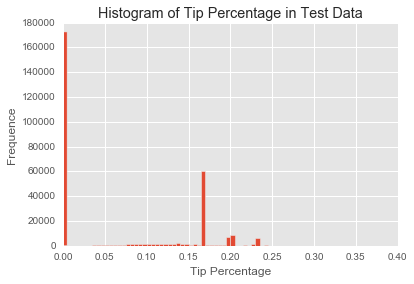

In [162]:
# Show histogram of tip percentage
test_data['tip_pct'].hist(bins = 200)
plt.xlim((0,0.4))
plt.title("Histogram of Tip Percentage in Test Data")
plt.xlabel('Tip Percentage')
plt.ylabel('Frequence')

In [163]:
# Get the importance of each variable  
variable_importance = reg.feature_importances_ 
variable_importance

array([ 0.08875,  0.     ,  0.     ,  0.3675 ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.5375 ,  0.     ,  0.00625,  0.     ])

In [164]:
# Get all the name of features
features = train_data.drop(['lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude','Pickup_latitude', 
                                  'Dropoff_longitude', 'Dropoff_latitude', 'Tip_amount', 'Total_amount', 'tip_pct']
                           , axis = 1).columns.tolist()

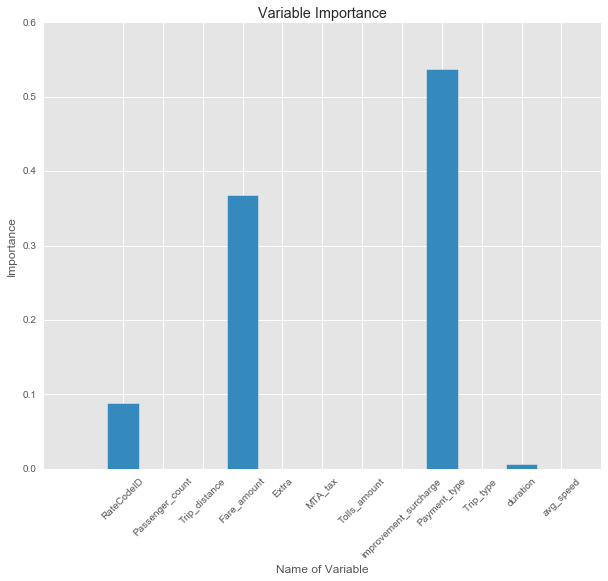

In [165]:
# Show importance of each variable 
fig = plt.figure(figsize = (10, 8))
axes = plt.subplot2grid((1,1), (0,0))
axes.bar(range(len(features)), variable_importance, align='center')
plt.xticks(range(len(features)), features)

# Rotate the angle of the labels
for label in axes.xaxis.get_ticklabels():
    label.set_rotation(45)
    
plt.title("Variable Importance")
plt.xlabel('Name of Variable')
plt.ylabel('Importance')   

### 5.2 Model Analysis
1. As the "Histogram of Tip Percentage in Test Data" above, the tip percentage are always 0% or from 8% to 24%. 

2. As the Variable Importance graph, the final model only use RateCodeID, Fare_amount, Payment_type and duration as its independent variables. Besides, Fare_amount and Payment_type have the significant impacts to the model result.

3. The test mean absolute error is around 0.027. Basically, it means on average the true tip percentage should between (our prediction - 2.7%, our prediction + 2.7%). Thus, we can assert that the model is pretty accurate.

4. Based on the OOB Error Improvement graph, 500 trees are enough for this model. Because at that point the OOB Error fall to 0. However, due to the small learning rate (0.01) in my model, the result from current model is still convincing.

### 5.3 Future Research
If I have more time,
* I will try to tune the three parameters (1. number of trees; 2. learning rate; 3. maximun depth) of this stochastic gradient boosting model.
* I will do more data cleaning on the high outliers in the large range set, which equal third quartile plus 1.5 times the result of third quartile minus the first quartile (high outliers = Q3 + 1.5*(Q3 - Q1)).